In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150
import numpy as np
import awkward as ak
import scipy.stats
import scipy.integrate
from scipy.interpolate import griddata, UnivariateSpline, RectBivariateSpline
import seaborn as sns
sns.set_context("paper")
import numba

from numba.typed import List
import mceq_config as mceqconfig
mceqconfig.floatlen = "float64"
mceqconfig.kernel_config = "numpy"
from MCEq.core import MCEqRun
import crflux.models as pm



from gnn_testbed.event_generation import (
    Detector,
    proposal_setup,
    generate_cascade,
    generate_realistic_tracks,
    make_line,
    trigger,
    get_proj_area_for_zen,
    
    
)

from gnn_testbed.event_generation.detector import sample_cylinder_surface
from gnn_testbed.plotting import plot_events, plot_event
from gnn_testbed.feature_generation import get_features
from gnn_testbed.event_generation.photon_propagation import BiolumiSource, generate_biolumi_photons, dejit_biolumi_sources
from gnn_testbed.event_generation.mc_record import MCRecord
from gnn_testbed.event_generation.utils import get_zen_azi
from gnn_testbed.event_generation import proposal_setup, Constants

prop = proposal_setup()

/opt/conda/lib/python3.8/site-packages/mceq_config.py:303: FutureWarning: Config dictionary is deprecated. Use 'import mceq_config as config' instead of 'from mceq_config import config'; and 'config.variable instead of config['variable']
  warnings.warn(warn_str, FutureWarning)


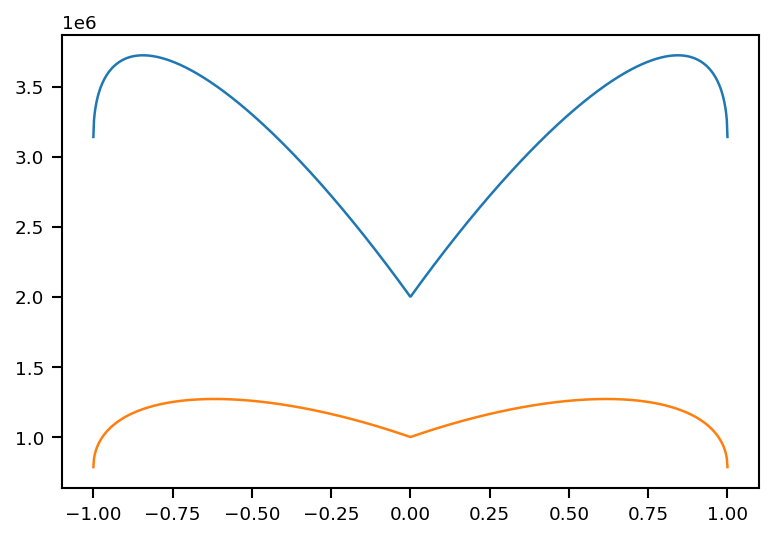

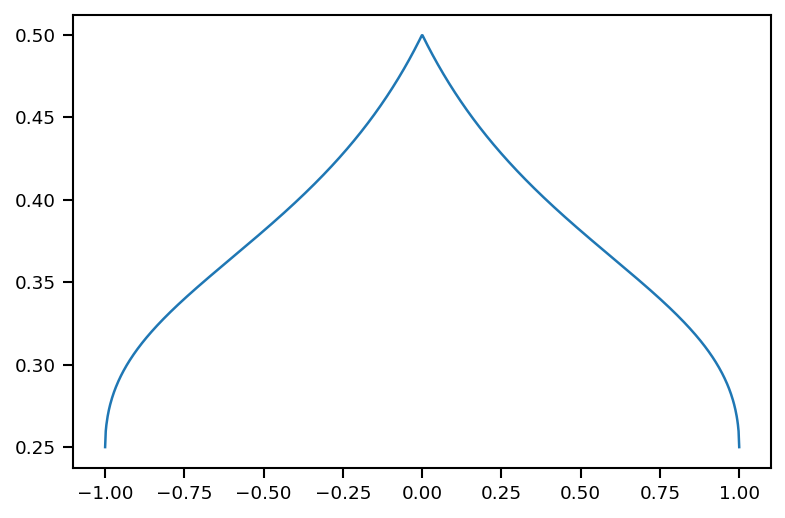

In [6]:
cz = np.linspace(-1, 1, 1000)
plt.plot(cz, get_proj_area_for_zen(1000, 1000, cz), label="PONE")
plt.plot(cz, get_proj_area_for_zen(1000, 500, cz), label="IC")
plt.figure()
plt.plot(cz, get_proj_area_for_zen(1000, 500, cz) / get_proj_area_for_zen(1000, 1000, cz), label="IC")
np.savetxt("HUT.txt", [cz, get_proj_area_for_zen(1000, 500, cz), get_proj_area_for_zen(1000, 1000, cz)])

In [2]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50

modules = make_line(-75, -65, dist_z, oms_per_line, rng, 16*1e-6, 0, efficiency=0.3)
modules += make_line(75, -65, dist_z, oms_per_line, rng, 16*1e-6, 0, efficiency=0.3)
modules += make_line(0, 65, dist_z, oms_per_line, rng, 16*1e-6, 0, efficiency=0.3)
det = Detector(modules)

lc_links = {}
for i in range(60):
  
    links = list(range(max(i-1, (i//20)*20), min(i+2, (i//20+1)*20)))
    links.remove(i)
    lc_links[i] = links

height = 1500
radius = 200
    

In [3]:
tracks, track_records = generate_realistic_tracks(det, height, radius, 50, seed=31337, propagator=prop, log_emin=1, log_emax=8, 
                                                 pprop_extras=dict(photocathode_area=16 * (7.62/2)**2 * np.pi * 1E-4,
                                                 lambda_abs=30, lambda_sca=100))

LOWER CAP:  [ -27.35430827   26.07908482 -550.        ]
UPPER CAP:  [112.35692396  48.15397629 550.        ]
LOWER CAP:  [ -79.86828957  -44.46598839 -550.        ]
UPPER CAP:  [  3.90645195 -36.73187618 550.        ]
LOWER CAP:  [ -59.38189651   15.41982913 -550.        ]
UPPER CAP:  [-72.25079684  -6.95650927 550.        ]



In [7]:
pickle.dump((tracks, track_records), open("pone_3str_tracks.pickle", "wb"))

In [3]:
tracks, track_records = pickle.load(open("training_data_tracks_pone.pickle", "rb"))

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(


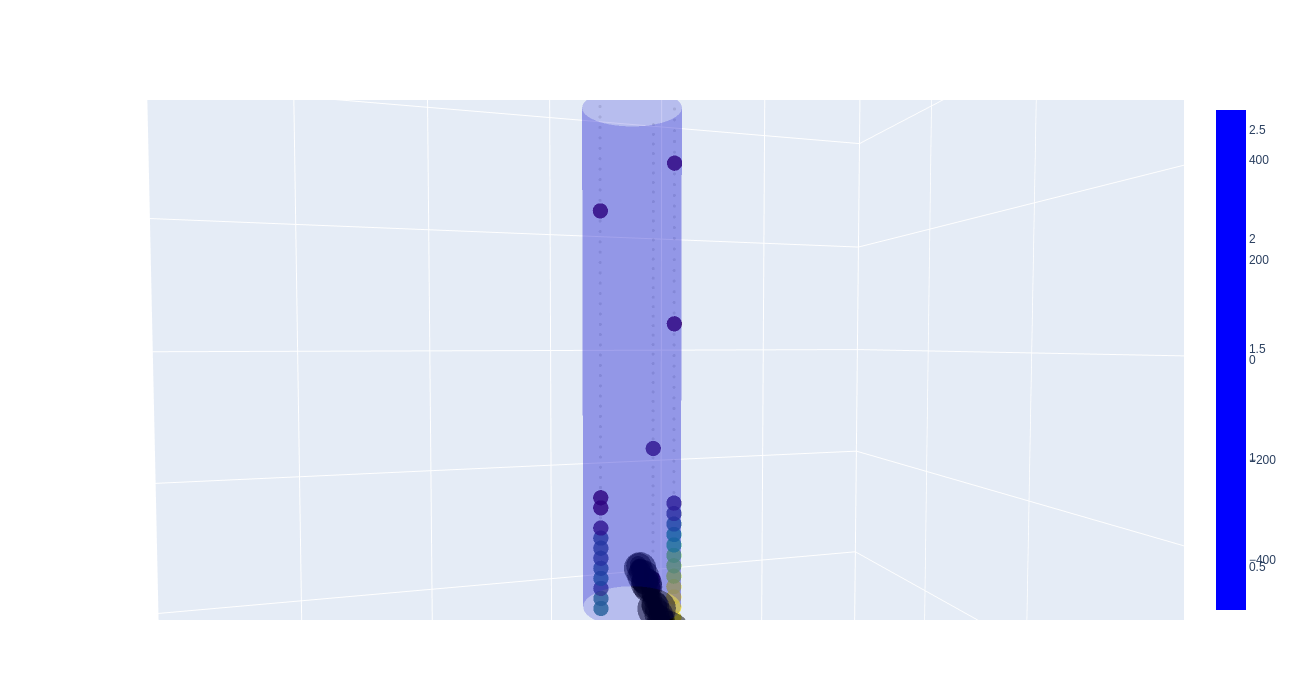

In [4]:
ix = 123
plot_event(det, tracks[ix], track_records[ix], plot_hull=True);


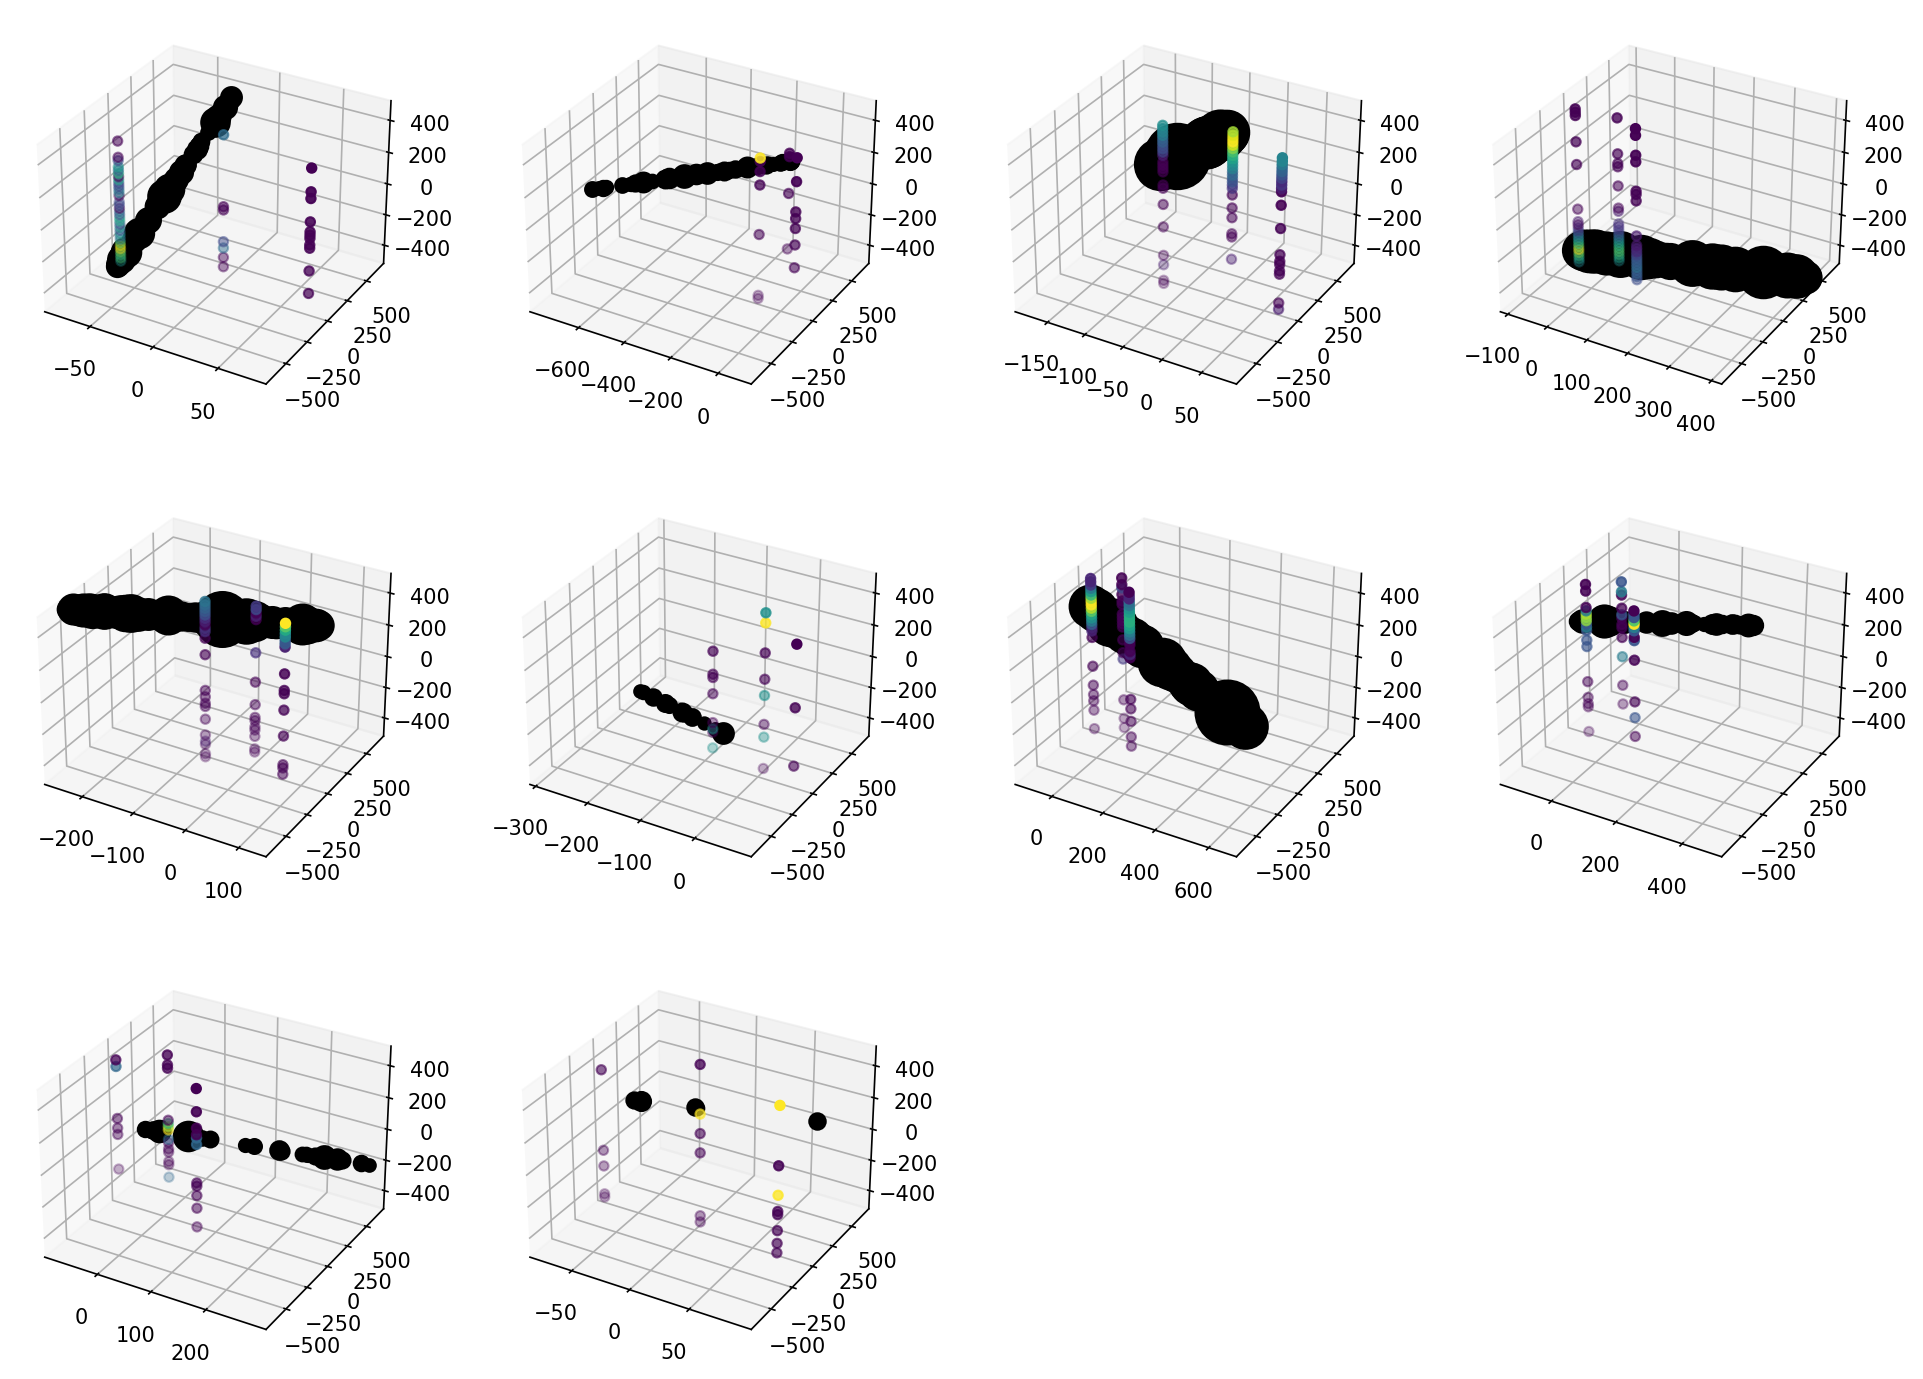

In [5]:
plot_events(det, tracks[10:20], records=track_records[10:20], );

In [6]:
triggers = []
for event in tracks:
    triggers.append(trigger(det, event, mod_thresh=3, phot_thres=5))
    
triggers_low = []
for event in tracks:
    triggers_low.append(trigger(det, event, mod_thresh=1, phot_thres=5))

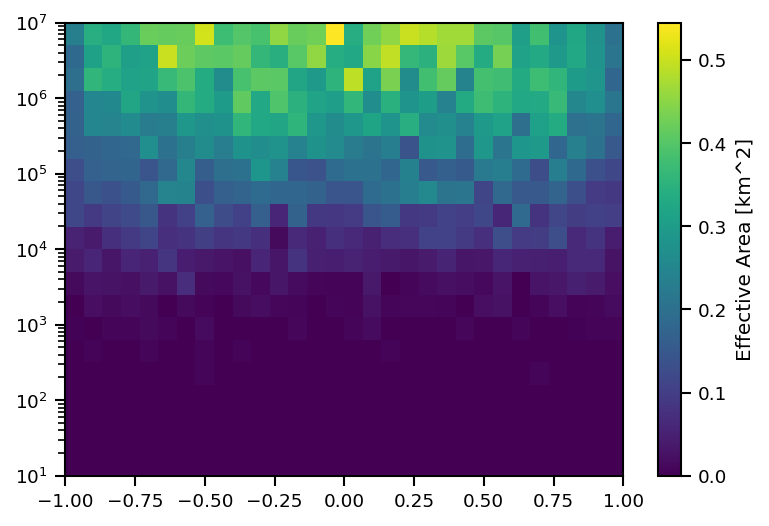

In [11]:
trigger_mask = np.asarray(triggers)

energies = np.asarray([tr.mc_info[0]["energy"][0] for tr in track_records])
coszeniths = np.cos([get_zen_azi(tr.mc_info[0]["direction"])[0] for tr in track_records])
weight = get_proj_area_for_zen(height, radius, coszeniths) *4*np.pi / len(tracks) * (np.log(10**7 / 10**1)/energies**-1)
ebins = np.logspace(1, 7, 21)
costbins = np.linspace(-1, 1, 31)
ctbinc = 0.5*(costbins[1:] + costbins[:-1])
thist, xedge, yedge = np.histogram2d(energies[trigger_mask], coszeniths[trigger_mask], bins=[ebins, costbins],
                                    weights=weight[trigger_mask])

thist = thist / ((np.diff(costbins) * 2*np.pi) * np.diff(ebins)[:, None])

plt.pcolormesh(yedge, xedge, thist / 1E6)
plt.semilogy()
cbar = plt.colorbar()
cbar.set_label("Effective Area [km^2]")

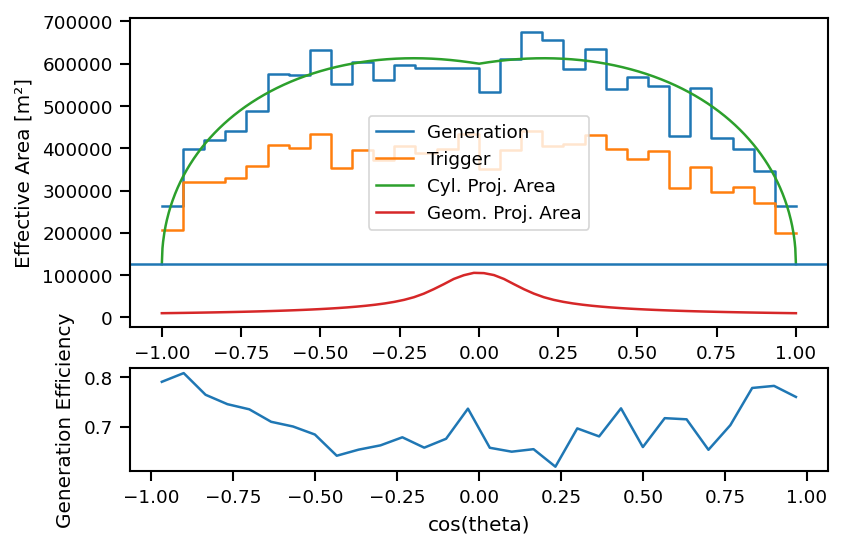

In [15]:
fig, axs = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1]))
hzen_gen, _ = np.histogram(coszeniths, bins=costbins, weights=weight)
hzen_gen /= (np.diff(costbins) * 2 * np.pi) * (10**7 - 10**1)
axs[0].step(costbins, np.append(hzen_gen, hzen_gen[-1]), where="post", label="Generation")

hzen, _ = np.histogram(coszeniths[trigger_mask], bins=costbins, weights=weight[trigger_mask])
hzen /= (np.diff(costbins) * 2 * np.pi) * (10**7 - 10**1)
axs[0].step(costbins, np.append(hzen, hzen[-1]), where="post", label="Trigger")


cz = np.linspace(-1, 1, 1000)
axs[0].plot(cz, get_proj_area_for_zen(height, radius, cz), label="Cyl. Proj. Area")
axs[0].plot(np.cos(zens), geom_proj_area, label="Geom. Proj. Area")
axs[1].plot(ctbinc,   hzen/hzen_gen)

axs[1].set_xlabel("cos(theta)")
axs[0].set_ylabel("Effective Area [m²]")
axs[1].set_ylabel("Generation Efficiency")
axs[0].axhline(radius**2 * np.pi)
axs[0].legend()


In [468]:
np.log(7)

1.9459101490553132

Text(0, 0.5, 'Effective Area [m²]')

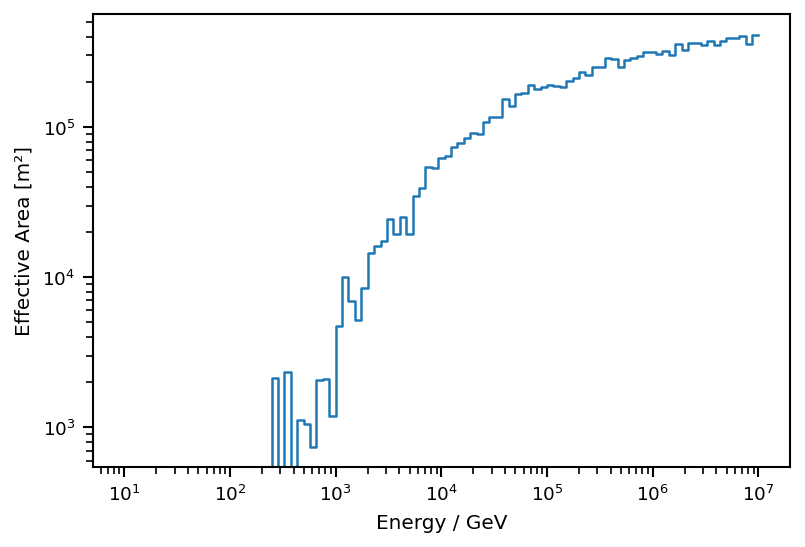

In [16]:
ebins = np.logspace(1, 7, 100)
hen, newbins = np.histogram(energies[trigger_mask], bins=ebins, weights=weight[trigger_mask])
hen = hen / (4 * np.pi) / np.diff(newbins)
plt.step(newbins, np.append(hen, hen[-1]), where="post")


plt.loglog()
plt.xlabel("Energy / GeV")
plt.ylabel("Effective Area [m²]")

In [492]:
mceqconfig.debug_level = 2
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.GlobalSplineFitBeta, None),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0
)


HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v131.h5
MCEqRun::set_interaction_model(): SIBYLL23C
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+", 
"mu-", "antinumu", "numu", "antinutau", "nutau", 
"gamma"

Tracking:


Total number of species: 30
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_theta_deg(): Zenith angle   0.00
MCEqRun::set_primary_model(): Primary model set to Global Spline Fit


In [93]:
#import solver related modules
mceqconfig.e_min = 10.
mceqconfig.enable_default_tracking = False
mceqconfig.muon_helicity_dependence = False
mceqconfig.dXmax = 1.
mceqconfig.debug_level = 0


mceqconfig.max_density = 0.001225
mceq_surface = MCEqRun(
    interaction_model='SIBYLL23d',
    primary_model=(pm.GlobalSplineFitBeta, None),
    theta_deg=0,
)
from MCEq.geometry.density_profiles import GeneralizedTarget
# Create a homogeneous target material
target_water = GeneralizedTarget(len_target=2000e2) # 2km
density = 1.
target_water.add_material(0.,density,'Water')

#mceqconfig.adv_set["exclude_from_mixing"] = [13, -13]
mceqconfig.leading_process = 'auto'
mceqconfig.max_density = density
mceq_water = MCEqRun(
    interaction_model = 'SIBYLL23d', #This doesn't matter if you only propagate muons 
    primary_model = None,
    theta_deg = None,
    medium='water',
    particle_list=[(13,0),(-13,0)],
    density_model = target_water,
)

In [94]:
#Solve at the surface
mceq_surface.solve()

In [95]:
#Copy the state (muon fluxes only here but can be the entire stack of densities)
mceq_water._set_state_vector(*mceq_surface._get_state_vector(), only_available=True)
depths = np.arange(10., 2000.1 , 10)*100 #read out at steps of 10 meters
#Solve in water
mceq_water.solve(int_grid=depths)

Text(0, 0.5, 'Vertical muon intensity (g cm$^2$ sr)$^{-1}$')

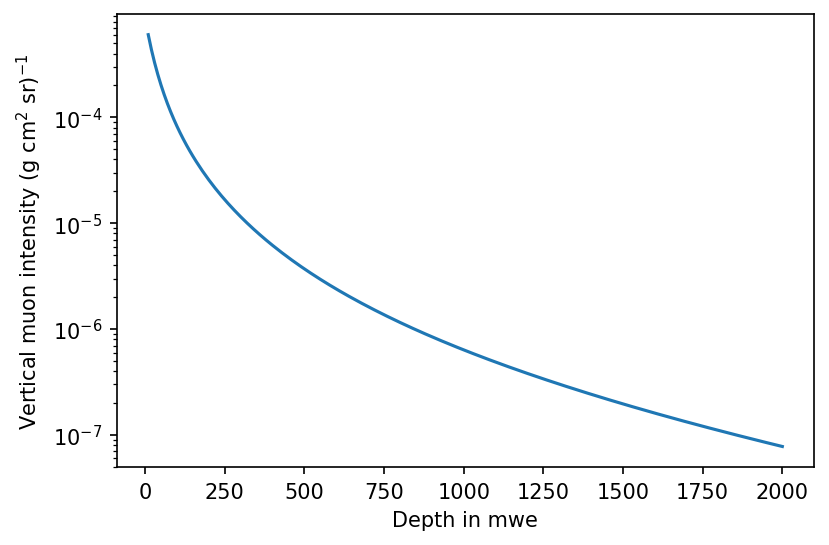

In [96]:
plt.semilogy(depths/1e2, np.sum([mceq_water.get_solution('mu+', integrate=True, grid_idx=i)
                             + mceq_water.get_solution('mu-', integrate=True, grid_idx=i)
                            for i in range(len(depths))], axis=1))
plt.xlabel('Depth in mwe')
plt.ylabel(r'Vertical muon intensity (g cm$^2$ sr)$^{-1}$')


[]

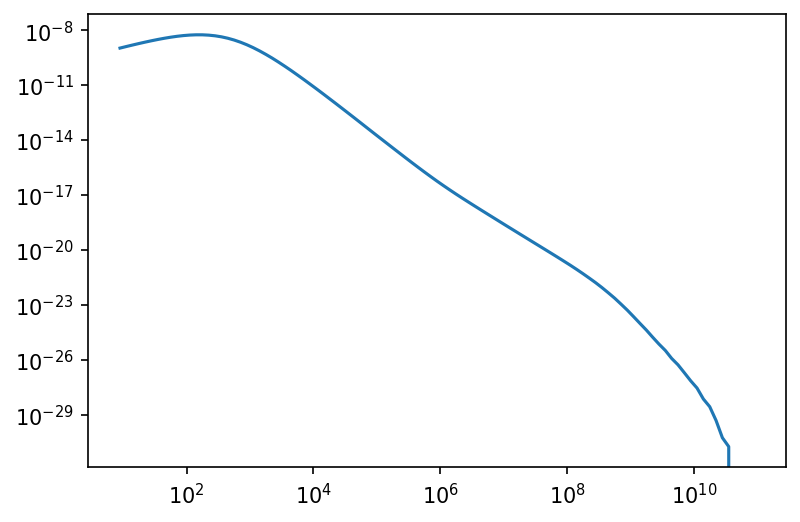

In [97]:
flux = mceq_water.get_solution('total_mu+', 0, integrate=True) + \
    mceq_water.get_solution('total_mu-', 0, integrate=True)
plt.plot(mceq_water.e_grid, flux)
plt.loglog()

In [98]:
mup_dict, numu_dict, nue_dict = {}, {}, {}

cost_steps_mceq = np.linspace(0.3, 1, 10)


for ctheta in cost_steps_mceq:
    mceq_surface.set_theta_deg(np.degrees(np.arccos(ctheta)))
    mceq_surface.solve()
    mceq_water._set_state_vector(*mceq_surface._get_state_vector(), only_available=True)
    
    target_water.set_length(2000 / ctheta * 100)
    mceq_water._calculate_integration_path(int_grid=depths, grid_var='X', force=True)
    
    mceq_water.solve()

    mag = 0

    mup_dict[ctheta] = mceq_water.get_solution('total_mu+', mag, integrate=True) + \
                           mceq_water.get_solution('total_mu-', mag, integrate=True)


(1e-20, 1e-08)

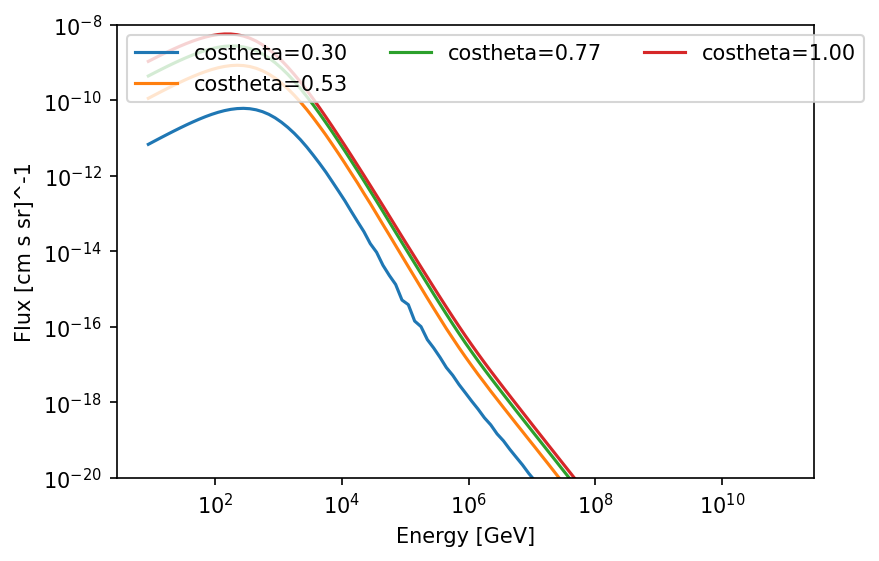

In [107]:
e_grid = mceq_water.e_grid

for theta in list(mup_dict.keys())[::3]:
    plt.plot(e_grid, mup_dict[theta], label=f"costheta={theta:.2f}")
plt.loglog()
plt.legend(loc="upper left", ncol=3)
plt.ylabel("Flux [cm s sr]^-1")
plt.xlabel("Energy [GeV]")
plt.ylim(1E-20, 1E-8)

In [115]:
flux_splines = {}
for ctheta, flux_points in mup_dict.items():
    y = np.log10(flux_points)
    valid_y = np.isfinite(y)
    flux_splines[ctheta] = UnivariateSpline(np.log10(e_grid[valid_y]), y[valid_y], s=0, k=1)


/tmp/ipykernel_82/4097243045.py:4: RuntimeWarning:

invalid value encountered in log10



(1e-09, 0.1)

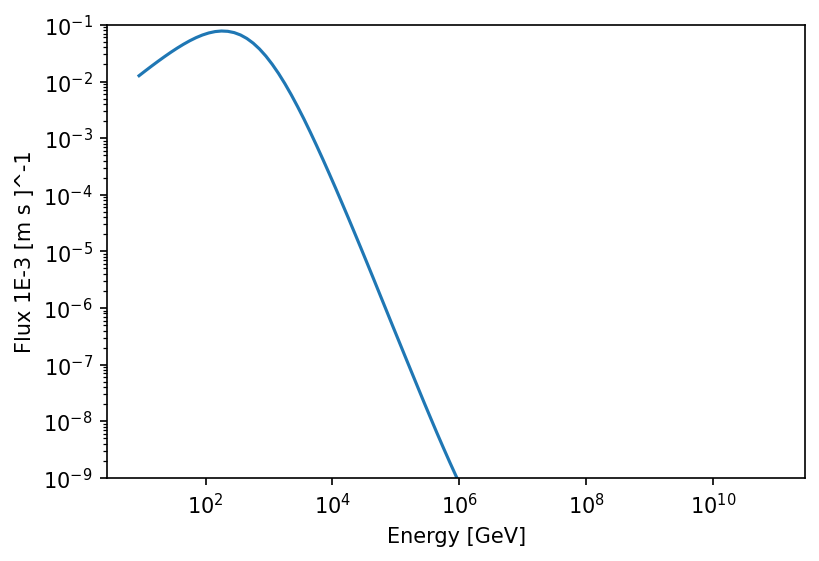

In [101]:
e_grid = mceq_water.e_grid

tot_fl = 0

for i, theta in enumerate(cost_steps_mceq[:-1]):
    tot_fl = tot_fl + mup_dict[theta] * 2*np.pi * np.diff(cost_steps_mceq[i:i+2]) * 1E4 * 1E3
    
    
plt.plot(e_grid, tot_fl)
plt.loglog()
plt.ylabel("Flux 1E-3 [m s ]^-1")
plt.xlabel("Energy [GeV]")
plt.ylim(1E-9, 1E-1)

/tmp/ipykernel_82/3756570488.py:6: RuntimeWarning:

invalid value encountered in log10

/tmp/ipykernel_82/3756570488.py:11: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.

/tmp/ipykernel_82/3756570488.py:27: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.

/tmp/ipykernel_82/3756570488.py:36: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and

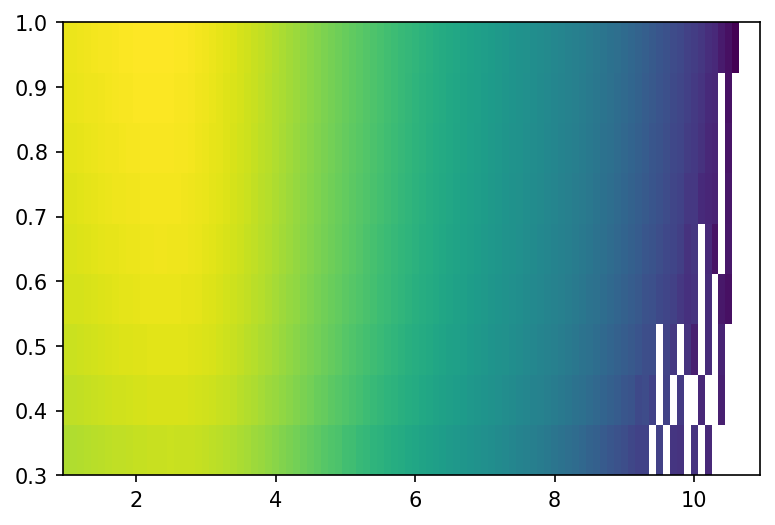

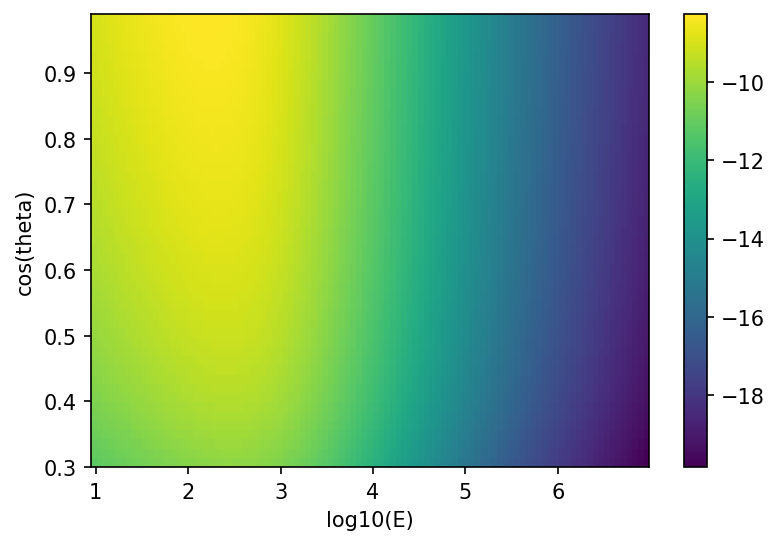

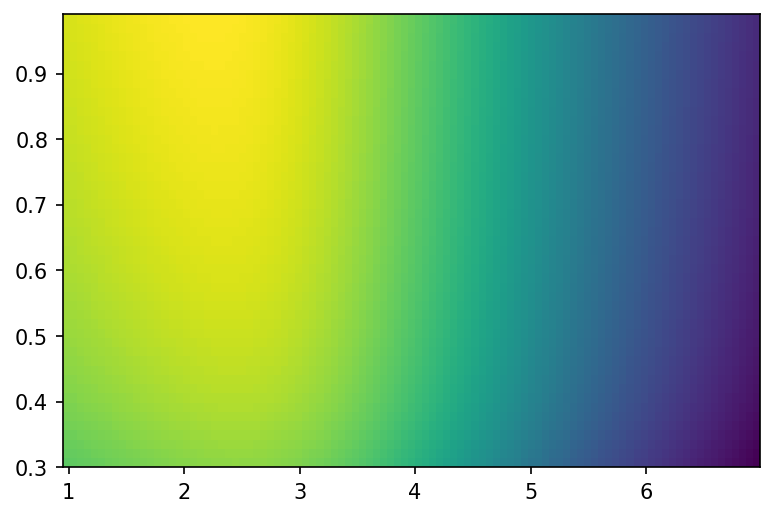

In [128]:
from scipy.interpolate import griddata
mup_grid = np.empty((e_grid.shape[0], len(mup_dict)))
for i, ct in enumerate(mup_dict.keys()):
    mup_grid[:, i] = mup_dict[ct]

log_mup_grid = np.log10(mup_grid)
mask = np.isfinite(log_mup_grid)



plt.pcolormesh(np.log10(e_grid), cost_steps_mceq, log_mup_grid.T)
plt.figure()

valid_idx = np.argwhere(mask)

px = np.log10(e_grid[valid_idx[:, 0]])
py = cost_steps_mceq[valid_idx[:, 1]]

xeval = np.linspace(np.log10(e_grid.min()), 6.99, 100)
yeval = np.linspace(cost_steps_mceq.min(), 0.99, 50)

X, Y = np.meshgrid(xeval, yeval)

log10_muon_flux = griddata((px, py), log_mup_grid[mask], (X, Y), method="cubic")


plt.pcolormesh(xeval, yeval, log10_muon_flux)
plt.colorbar()
plt.ylabel("cos(theta)")
plt.xlabel("log10(E)")


log10_muon_flux_spl = RectBivariateSpline(xeval, yeval, log10_muon_flux.T, kx=1, ky=1, s=0)

plt.figure()
plt.pcolormesh(xeval, yeval, log10_muon_flux_spl(xeval, yeval).T)


In [493]:
flux_weights = 10**log10_muon_flux_spl(np.log10(energies), coszeniths, grid=False)*1E4 * weight

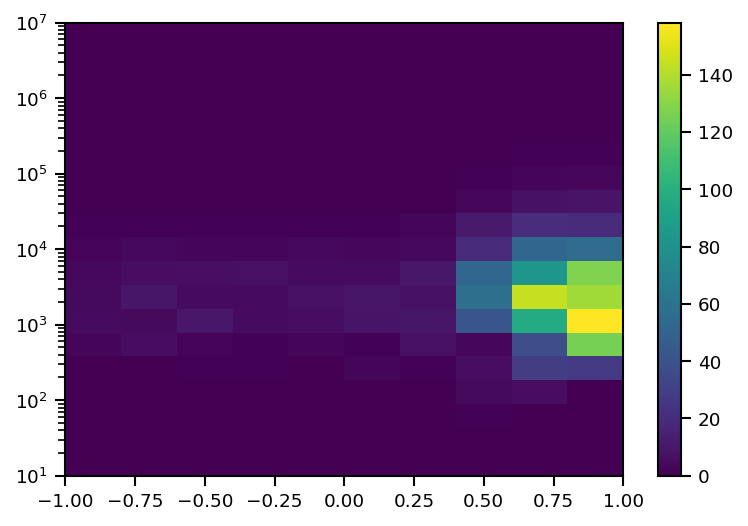

In [494]:
trigger_mask = np.asarray(triggers_low)

energies = np.asarray([tr.mc_info[0]["energy"][0] for tr in track_records])
coszeniths = np.cos([get_zen_azi(tr.mc_info[0]["direction"])[0] for tr in track_records])

ebins = np.logspace(1, 7, 20)
costbins = np.linspace(-1, 1, 11)
ctbinc = 0.5*(costbins[1:] + costbins[:-1])
thist, xedge, yedge = np.histogram2d(energies[trigger_mask], coszeniths[trigger_mask], bins=[ebins, costbins],
                                    weights=flux_weights[trigger_mask])

plt.pcolormesh(yedge, xedge, thist)
plt.semilogy()
plt.colorbar()

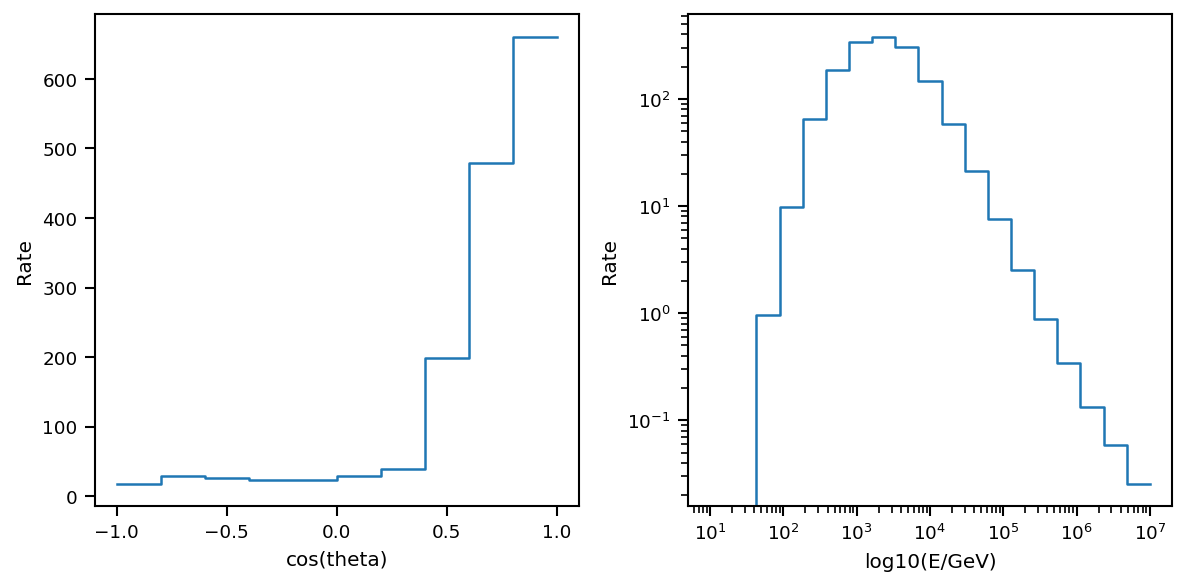

In [496]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
proj = thist.sum(axis=0)
axs[0].step(costbins, np.append(proj, proj[-1]), where="post")
axs[0].set_xlabel("cos(theta)")
axs[0].set_ylabel("Rate")

proj = thist.sum(axis=1)
axs[1].step(ebins, np.append(proj, proj[-1]), where="post")
axs[1].set_xlabel("log10(E/GeV)")
axs[1].set_ylabel("Rate")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
#axs[1].set_ylim(1E-6, )
plt.tight_layout()

(2.5, 7)

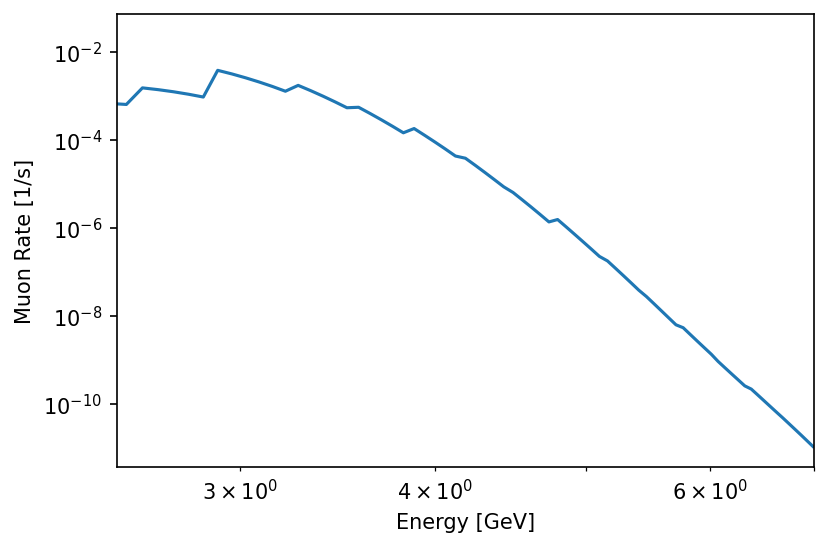

In [106]:
plt.plot(xeval, np.asarray(rates)) #FUDGE BECAUSE 4pi INJECTTION
plt.loglog()
#plt.xlim(1E2, 1E7)
#plt.ylim(1E-4, 1E3)
plt.xlabel("Energy [GeV]")
plt.ylabel("Muon Rate [1/s]")
plt.xlim(2.5, 7)
#plt.ylim(1E-3, 1E-1)

[]

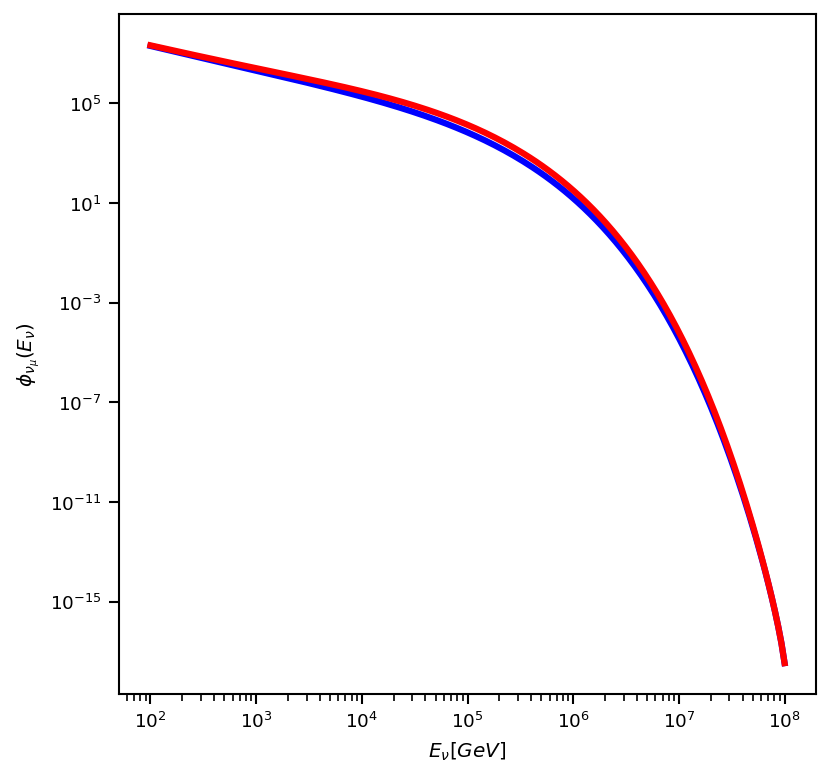

In [13]:
import nuSQuIDS as nsq

units = nsq.Const()


interactions = True

E_min = 1.0e2*units.GeV
E_max = 1.0e8*units.GeV
E_nodes = 200
energy_nodes = nsq.logspace(E_min,E_max,E_nodes)

neutrino_flavors = 3

nuSQ = nsq.nuSQUIDS(energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)


N0 = 1.0e18; Power = -1.0
Eflux = lambda E: N0*E**Power

InitialFlux = np.zeros((200,2,3))
for i,E in enumerate(nuSQ.GetERange()):
    InitialFlux[i][0][0] = 0.0
    InitialFlux[i][1][0] = 0.0
    InitialFlux[i][0][1] = Eflux(E)
    InitialFlux[i][1][1] = Eflux(E)
    InitialFlux[i][0][2] = Eflux(E)
    InitialFlux[i][1][2] = Eflux(E)

nuSQ.Set_rel_error(1.0e-7)
nuSQ.Set_abs_error(1.0e-7)
nuSQ.Set_h_max(500.0*units.km)
nuSQ.Set_MixingParametersToDefault()


nuSQ.Set_Body(nsq.EarthAtm())
nuSQ.Set_Track(nsq.EarthAtm.Track(np.arccos(-1.0)))
nuSQ.Set_initial_state(InitialFlux,nsq.Basis.flavor)
nuSQ.Set_TauRegeneration(True)

nuSQ.EvolveState()



nu_tau = np.array([ nuSQ.EvalFlavorAtNode(2,ie,0) for ie,EE in enumerate(nuSQ.GetERange())])
nu_tau_bar = np.array([ nuSQ.EvalFlavorAtNode(2,ie,1) for ie,EE in enumerate(nuSQ.GetERange())])

nu_mu = np.array([ nuSQ.EvalFlavorAtNode(1,ie,0) for ie,EE in enumerate(nuSQ.GetERange())])
nu_mu_bar = np.array([ nuSQ.EvalFlavorAtNode(1,ie,1) for ie,EE in enumerate(nuSQ.GetERange())])

E_range = nuSQ.GetERange()/units.GeV

plt.figure(figsize = (6,6))
plt.xlabel(r"$E_\nu [GeV]$")
plt.ylabel(r"$\phi_{\nu_\mu} (E_\nu)$")

plt.plot(E_range,nu_mu+nu_mu_bar, lw = 3, color = 'blue')
plt.plot(E_range,nu_tau+nu_tau_bar, lw = 3, color = 'red')
plt.loglog()


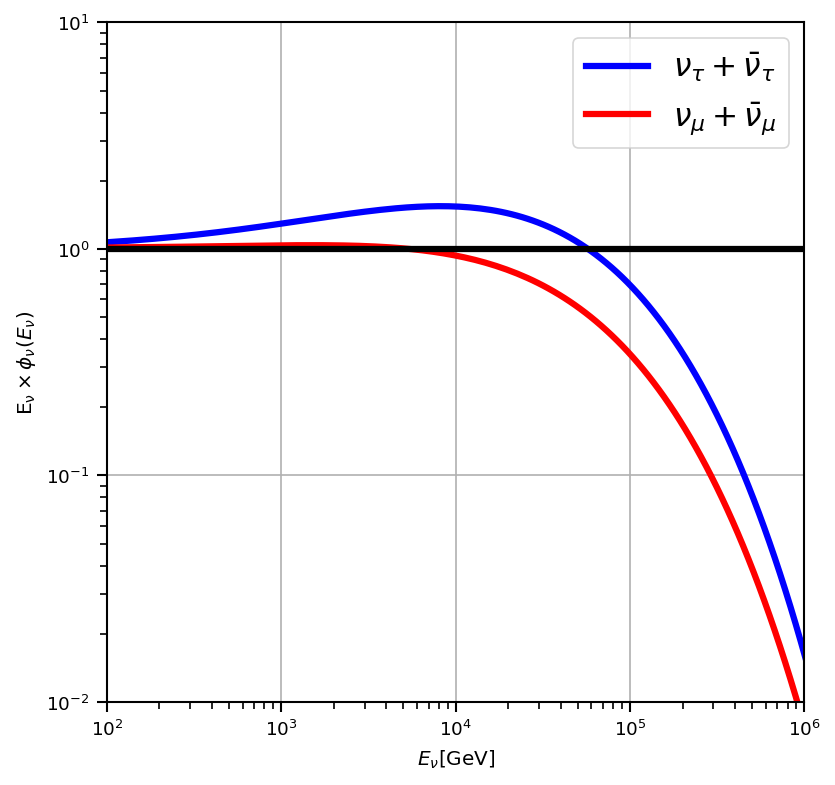

In [14]:


plt.figure(figsize = (6,6))
plt.xlabel(r"$E_\nu [{\rm GeV}]$")
plt.ylabel(r"${\rm E_\nu} \times \phi_\nu (E_\nu)$")
e_range = nuSQ.GetERange()/units.GeV
plt.plot(e_range,0.5*(nu_tau+nu_tau_bar)*(e_range*units.GeV)/N0, lw = 3, label =r"$\nu_\tau + \bar{\nu}_\tau$", color = "blue")
plt.plot(e_range,0.5*(nu_mu+nu_mu_bar)*(e_range*units.GeV)/N0, lw = 3, label =r"$\nu_\mu + \bar{\nu}_\mu$", color = "red")
plt.axhline (1.0, color = "k", lw = 3)
plt.xlim(1.0e2,1.0e6)
plt.ylim(1.0e-2,1.0e1)
plt.grid()
plt.loglog()
plt.legend(loc = "upper right", fancybox = True, fontsize = 15)

In [ ]:
nu_e = np.array([nuSQ.EvalFlavorAtNode(0,ie,0) 
                           for ie in range(E_nodes)])
nu_mu = np.array([nuSQ.EvalFlavorAtNode(1,ie,0) 
                           for ie in range(E_nodes)])
nu_tau = np.array([nuSQ.EvalFlavorAtNode(2,ie,0) 
                           for ie in range(E_nodes)])

E_range = np.array(nuSQ.GetERange())/units.GeV

total = nu_e + nu_mu + nu_tau

In [14]:
from Geometry3D import ConvexPolyhedron, ConvexPolygon, Point, intersection, Renderer, Plane, origin, Vector, set_eps
set_eps(1E-5)
def to_cart(zen, azi):
    if zen != np.pi:
        x = np.sin(zen) * np.cos(azi)
        y = np.sin(zen) * np.sin(azi)
    else:
        x = 0
        y = 0    
    z = np.cos(zen)
    return Vector([x, y, z])

det_hull = scipy.spatial.ConvexHull(det.module_coords)
polys = []
for simp in det_hull.simplices:
    poly = ConvexPolygon([Point(det.module_coords[ps]) for ps in simp])
    polys.append(poly)
det_hull = ConvexPolyhedron(polys)

geom_proj_area = []
zens = np.linspace(0, np.pi, 100)
for zen in zens:
    areas = []
    sampler = scipy.stats.qmc.Sobol(d=1, scramble=True)
    azis = sampler.random_base2(m=5).squeeze() * 2*np.pi

    for azi in azis:
        plane = Plane(origin(), to_cart(zen, azi))
        try:
            isec = intersection(det_hull, plane)
            areas.append(isec.area())
        except (ValueError, ZeroDivisionError):
            areas.append(np.nan)

    geom_proj_area.append(np.ma.average(np.ma.masked_invalid(areas)))


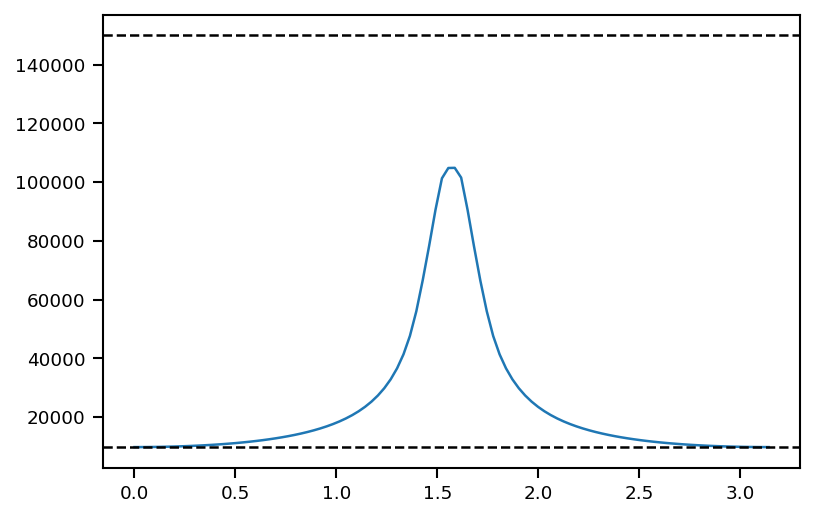

In [390]:
plt.plot(zens, geom_proj_area)
plt.axhline(150**2 / 4 * np.sqrt(3), color="k", ls="--")
plt.axhline(150 * 1000, color="k", ls="--")

130000.0000000002


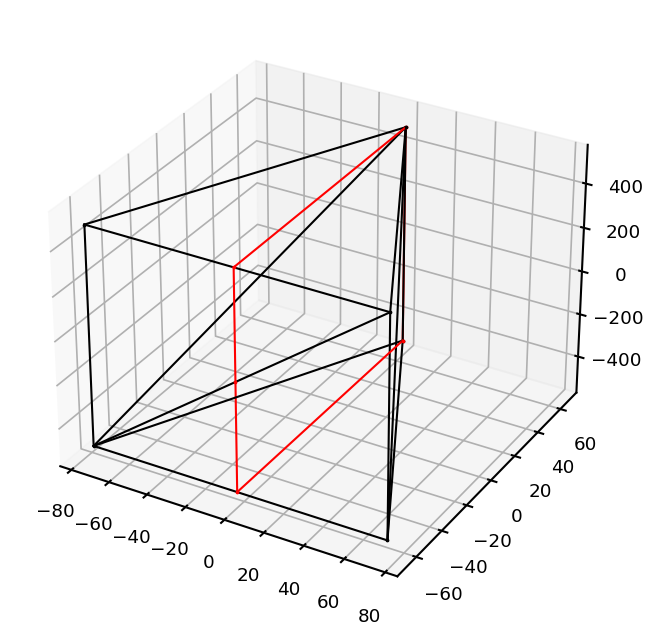

In [383]:
r = Renderer(backend='matplotlib')
plane = Plane(origin(), to_cart(np.pi/2, 0))
isec = intersection(det_hull, plane)
print(isec.area())
r.add((pp, "k", 1))
r.add((isec, "r", 1))
r.show()


In [307]:
ConvexPolygon([Point(1, 0, 0), Point(0, 1, 0), Point(0, 0, 1)])

ConvexPolygon((Point(1, 0, 0), Point(0, 1, 0), Point(0, 0, 1)))

In [302]:
ps = [Point(det.module_coords[ps]) for ps in hull.vertices]

In [303]:
ps

[Point(-75.0, -65.0, -500.0),
 Point(-75.0, -65.0, 500.0),
 Point(75.0, -65.0, -500.0),
 Point(75.0, -65.0, 500.0),
 Point(0.0, 65.0, -500.0),
 Point(0.0, 65.0, 500.0)]

In [304]:

p1 = origin()
#p = Plane(p1, Vector(1,1,1))

cpg = ConvexPolygon(ps)
r.add((cpg, "k", 1))
r.show()

ValueError: Convex Check Fails Because Point(0.0, 65.0, -500.0) Is Not On Plane(Point(-75.0, -65.0, -500.0), Vector(0.0, 1.0, 0.0))